### Test of data instantiation

In [1]:
import torch
import numpy as np
from paddleocr import PaddleOCR
import paddle
import cv2
from torch.utils.data import DataLoader 

import os
import torchvision.transforms as T
from torchvision.transforms import functional as F

import src.dfmaker as dfmaker
import src.BWDatasets as BWDatasets
import src.utility as utility
import src.train_eval as te


c:\Users\Kris\OneDrive\VSC_git\Bird-Is-The-Word\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Kris\OneDrive\VSC_git\Bird-Is-The-Word\.venv\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:717: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


### Ensure Reproducibility

In [2]:
seed = 115
generator = torch.Generator()
generator.manual_seed(seed)
np_generator = np.random.default_rng(seed=seed)

### Activate CUDA

In [3]:
device = torch.device('cpu')

# Make sure the notebook is deterministic if training on gpu
if torch.cuda.is_available():
    device = torch.device('cuda')
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False

print(f'Cuda availability is: {torch.cuda.is_available()}')  # Returns True if a GPU is available
print(f"Training on device {device}.")

Cuda availability is: True
Training on device cuda.


In [4]:
# Lyngøy
label_path_lyng = "dataset/datasets/lyngoy/ringcodes.csv"
image_path_lyng = "dataset/datasets/lyngoy/images"
bb_path_lyng = "dataset/datasets/lyngoy/labels"

# RF
label_path_rf = "dataset/datasets/rf/ringcodes.csv"
image_path_rf = "dataset/datasets/rf/images"
bb_path_rf = "dataset/datasets/rf/labels"

# Ringmerkingno
label_path_rno = "dataset/datasets/ringmerkingno/ringcodes.csv"
image_path_rno = "dataset/datasets/ringmerkingno/images"
bb_path_rno = "dataset/datasets/ringmerkingno/labels"

max_n_single = 10
max_n_all = None
height = 240 # 240 worked best for the provided dataset
transform = T.Compose([
    T.Lambda(lambda x: F.rotate(x, -90, expand=True)),
    T.Resize((height, utility.find_width(height))) 
])

df_lyng = dfmaker.make_dataframe(labels_path=label_path_lyng, img_path=image_path_lyng, bb_path=bb_path_lyng, max_n=max_n_single)
df_rf = dfmaker.make_dataframe(labels_path=label_path_rf, img_path=image_path_rf, bb_path=bb_path_rf, max_n=max_n_single)
df_rno = dfmaker.make_dataframe(labels_path=label_path_rno, img_path=image_path_rno, bb_path=bb_path_rno, max_n=max_n_single)
complete_df = dfmaker.combine_dfs([df_lyng, df_rf, df_rno])

exp_dataset = BWDatasets.TrainDataSet(df=complete_df, transform=transform, max_n=max_n_all)


In [5]:
#std, mean = torch.std_mean(exp_dataset[:]["ocr_image"], (0,2,3))

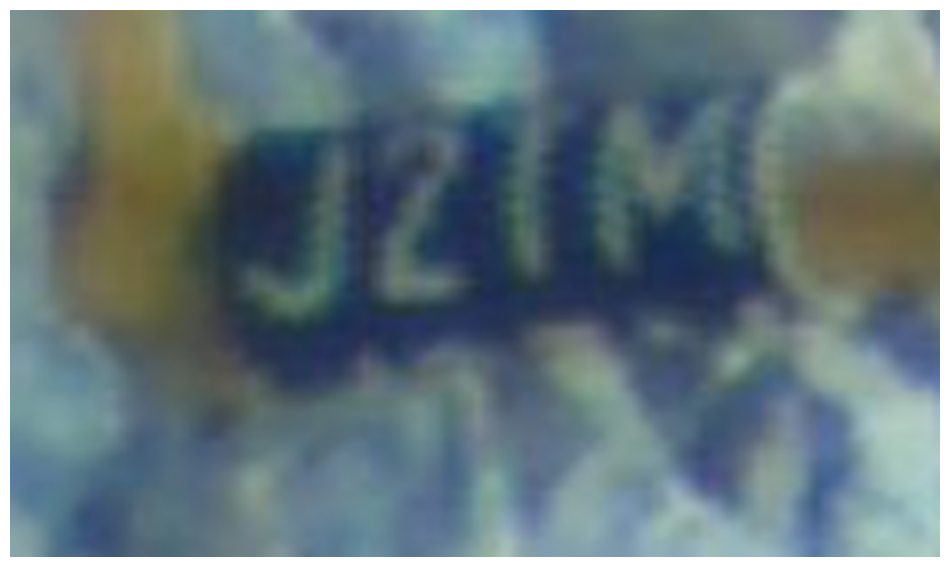

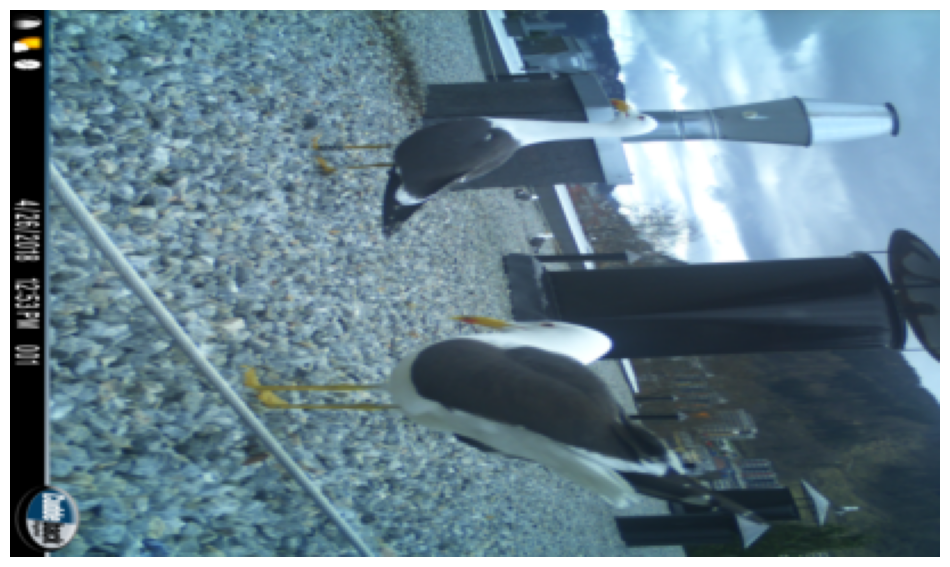

In [6]:
data = exp_dataset[0]

utility.draw_image(data["ocr_image"])
utility.draw_image(data["image"])


In [7]:
#stop



In [8]:
paddle.device.set_device("gpu:0")
ocr = PaddleOCR(lang="en", 
           use_doc_orientation_classify=True, 
           use_doc_unwarping=True, 
           use_textline_orientation=True, device='gpu')


TypeError: PaddlePredictorOption.__init__() takes 1 positional argument but 2 were given

In [ ]:
exp_loader = DataLoader(dataset=exp_dataset, batch_size=64, shuffle=False, generator=generator)


In [ ]:
preds, labels = te.prediction(exp_loader, ocr)


In [ ]:
evaluation = te.evaluate_model(preds=preds, labels=labels)

F1 Score: 0.43478259444236755
Accuracy: 0.13333334028720856


In [ ]:
print(f'F1 Score: {evaluation["F1 Score"]}')
print(f'Accuracy: {evaluation["Accuracy"]}')
print(f'Not Found: {evaluation["Not Found"]}')
print(f'Wrong: {evaluation["Wrong"]}')
print(f'Correct: {evaluation["Correct"]}')


NameError: name 'evaluation' is not defined